In [139]:
'''Decoder'''
import numpy as np
import copy
from itertools import permutations,combinations_with_replacement
from collections import defaultdict,Counter

class verterbi_model:
    def __init__(self,label=[1,-1],stages=50,initial=(1,1)):
        self.temp=label
        self.stages=stages
        self.initial=initial
        b=permutations(label,2)
        c=combinations_with_replacement(label,2)
        self.label=list(set(list(b)+list(c)))
        self.label.sort(reverse=True)
#         print('Rows:',self.label)
        
    def work(self,noise):
        self.noise=noise # noise=r-values
        x=[self.initial]
        refer=[[self.label[j] for i in range(self.stages)] for j in range(len(self.label))]
        path=defaultdict(list)
        c=0
        path[c]=x
        for i in range(len(refer[0])): # Columns (stages)
            ele=[]
            temp=defaultdict(list)
            for j,k in path.items():
                d=0
                for l in range(len(self.label)): #  rows (stages)
                    if self.label[l][1]==k[i][0]:
                        m=str(j)+str(d)
                        temp[m]=k+[self.label[l]]
                        ele.append(self.label[l])
                        d+=1
            asem=[0 if we==1 else 1 for we in list(dict(Counter(ele)).values())]
            if any(asem): # remove path with common node
                path=self.removing(temp,ele)
            else:
                path=copy.deepcopy(temp)
#             print(f'for {i} column',path)
#             if i==2:
#                 break
#         print('main',path) 
        best_path,score=self.get_score(path)
        seq=[]
        wes=list(best_path.values())[0]
        for yt in range(1,len(wes)):
            seq.append(wes[yt][0])
        return seq
    
    def removing(self,data,last):
        main={}
        repeats=dict(Counter(last))
        for i,j in repeats.items():
            if j>1:
                temp={}
                for k,l in data.items():
                    if i==l[-1]:
                        temp[k]=l
#                 print('Before removal',temp)
                new_temp,waste=self.get_score(temp)
#                 print('after removal',new_temp)
                chavi=list(new_temp.keys())[0]
                main[chavi]=new_temp[chavi]
            else:
                main[i]=j
        return main
                
    def get_score(self,data):
        temp={}
        new_temp={}
        for i,j in data.items():
            c=[]
            for k in range(1,len(j)):
                val=self.formula(j[k][0],j[k-1][0],j[k-1][1],self.noise[k-1])
                c.append(val)
#                 print(val)
#             print(i,j)
            temp[i]=sum(c)
        temp_data=sorted(temp.items(),key=lambda x:x[1],reverse=False)# 'False' to get lowest value and 'True' to get highest value
        temp_score=dict(sorted(temp.items(),key=lambda x:x[1],reverse=False))
        new_temp[temp_data[0][0]]=data[temp_data[0][0]]
        return new_temp,temp_score
    
    def formula(self,x1,x2,x3,r):
        y=x1+(1/2)*x2+(1/4)*x3
        node=(r-y)**2
        return node

# a=verterbi_model([1,-1],5,(1,1)).work([1.78,-0.35,0.8,1.1,0.-1.2,-1])
# verterbi_model(label,stages,r-values).path(initial_point)

In [145]:
import numpy as np
import time
import random
class song_to_binary:
    def __init__(self,song_file):
        self.data=[]
        with open(song_file,'r') as inpt:
            for i in inpt:
                line=i.rstrip()
#                 print(line)
                bi=''.join(format(ord(i), '08b') for i in line)
#                 print(bi)
                self.data.append(bi)
        self.total=''.join(self.data)
        
    def y_and_r(self):
        self.r_value=[]
        for i in range(2,len(self.total)):
            tem=[self.total[i-2],self.total[i-1],self.total[i]]
            tem=[int(j) if int(j)==1 else -1 for j in tem]
            yy=self.formula(tem[0],tem[1],tem[2])
            random.seed(44)
            n=np.random.normal(0,0.7,1)#######################################################################################
            self.r_value.append(yy+n[0])
        return self.r_value
    
    def formula(self,x3,x2,x1):
        y=x1+(1/2)*x2+(1/4)*x3
        return y
        
    def output(self,song_bi):
        out=open(song_bi,'w')
        for yu in self.total:
            out.write(yu)
        out.close()
#         print('Downloaded binary code of the song !!!')
    
sss=song_to_binary('alphafold_abstract.txt')
song_out=sss.output('alphafold_abstract_binary.txt')
asd=sss.y_and_r()


In [155]:
class get_error:
    def __init__(self,data,window,init_state):
        self.data_col={}
        self.data_time={}
        self.ref=[int(i) for i in sss.total]
        for i in window:
            start=time.perf_counter()
            temp=[init_state[0],init_state[1]]
            big=len(data)-len(data)%i
            part1=data[:big]
            part2=data[big:]
            in_state=init_state
            for j in range(0,len(part1),i):
                a=verterbi_model([1,-1],i,in_state).work(part1[j:j+i])
                in_state=(a[-1],a[-2])
                a=[1 if m==1 else 0 for m in a]
                temp.extend(a)
            a=verterbi_model([1,-1],len(part2),in_state).work(part2)
            a=[1 if m==1 else 0 for m in a]
            temp.extend(a)
            end=time.perf_counter()
            self.data_col[i]=self.error(temp)
            self.data_time[i]=end-start
            print(f'Time taken by window size {i}:',end-start)
            
    def error(self,result):
        temp=[]
        for i,j in zip(self.ref,result):
            t=str(i)+str(j)
            temp.append(t)
        te=dict(Counter(temp))
        print(te)
        match,mismat=[],[]
        for k in te.keys():
            if k[0]==k[1]:
                match.append(te[k])
            else:
                mismat.append(te[k])
        match=sum(match)
        mismat=sum(mismat)
        err_val=mismat/(match+mismat)
        return err_val
              
wer=get_error(asd,[50],(1,1))

AttributeError: 'dict' object has no attribute 'perf_counter'

In [154]:
error=wer.data_col
error

{50: 0.07700205338809035,
 100: 0.07663537694338515,
 200: 0.07663537694338515,
 300: 0.07648870636550308,
 400: 0.07648870636550308,
 500: 0.07626870049867997,
 600: 0.07648870636550308,
 700: 0.07656204165444412,
 800: 0.07648870636550308,
 900: 0.07648870636550308,
 1000: 0.07648870636550308}

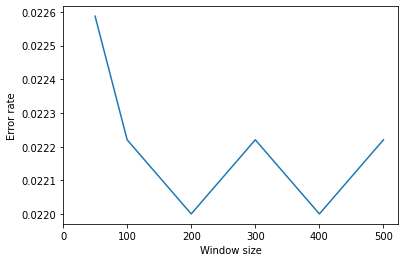

In [153]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(list(error.keys()),list(error.values()))
# ax.set_title('Error rate')
ax.set(xlabel='Window size',ylabel='Error rate')
ax.set_xlim(left=0)
# ax.set_xlim([50, 500])
fig.savefig('error.png',dpi=300)

In [148]:
time=wer.data_time
time

{50: 2.7596095000044443,
 100: 5.034068500004651,
 200: 9.617254500000854,
 300: 14.195428400002129,
 400: 18.9560261000006,
 500: 23.523509699996794,
 600: 28.291455999999016,
 700: 32.91718579999724,
 800: 38.081503800000064,
 900: 42.74857150000025,
 1000: 47.190602099995886}

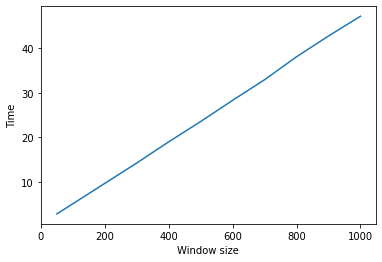

In [152]:
fig1,ax1=plt.subplots()
ax1.plot(list(time.keys()),list(time.values()))
# ax1.set_title('')
ax1.set(xlabel='Window size',ylabel='Time')
ax1.set_xlim(left=0)
# ax.set_xlim([50, 500])
fig1.savefig('time.png',dpi=300)
